In [1]:
import os, glob
import pandas as pd
from helper import *
import datetime
import numpy as np
from sklearn import preprocessing
import statsmodels.formula.api as smf
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline


pwd = os.path.dirname(os.path.realpath('.'))
data_folder = pwd + '/Data'
data_2018 = data_folder + '/2018'

In [7]:
list_of_speed_files_2018 = glob.glob(data_2018+'/speed_for_chunks/*')
list_of_csv_files_2018 = glob.glob(data_2018+'/2018_results/*')
annotations = pd.read_excel(data_2018+'/annotation.xlsx')
# len(list_of_csv_files_2018)

In [8]:
#  filter unvalid files
annotations = annotations[annotations.is_valid == 'Y']

In [4]:
name_of_csv_files_2018 = [i.split('/')[-1].split('.')[0] for i in list_of_csv_files_2018]
valid_files = [i for i in annotations.filename]
cnt = 0
for i in valid_files:
    if i in name_of_csv_files_2018:
        cnt += 1
assert cnt == len(valid_files), "Not all the files found!"

Processing file:  unit01_2018-09-26_20_38_20_1_2832
Processing file:  unit01_2018-09-26_22_29_30_1_7032
Processing file:  unit01_2018-09-26_22_29_30_4_28392
Processing file:  unit01_2018-09-26_23_17_50_3_25560
Processing file:  unit01_2018-10-17_15_03_17_15_83064
Processing file:  unit01_2018-10-18_15_22_15_1_66288
Processing file:  unit01_2018-10-19_21_13_40_1_1
Processing file:  unit01_2018-10-20_16_57_49_2_103512
Processing file:  unit01_2018-10-20_16_57_49_3_105384
Processing file:  unit01_2018-10-21_19_16_24_1_480
433  files remained!
10  file processed!


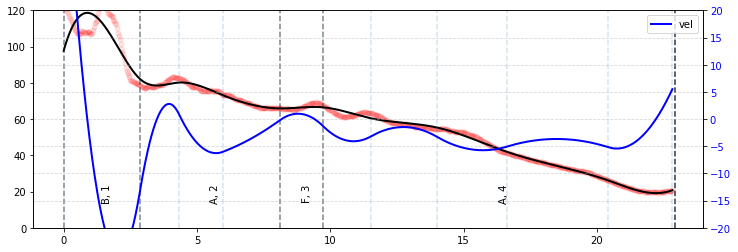

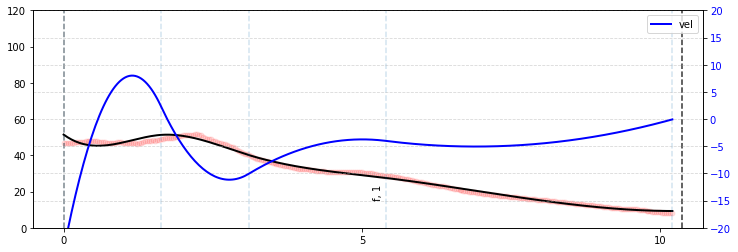

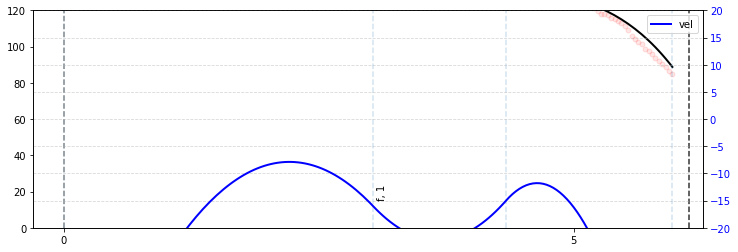

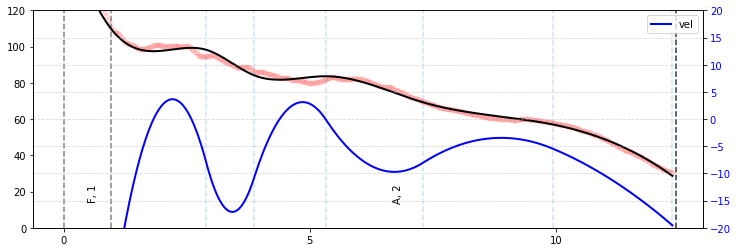

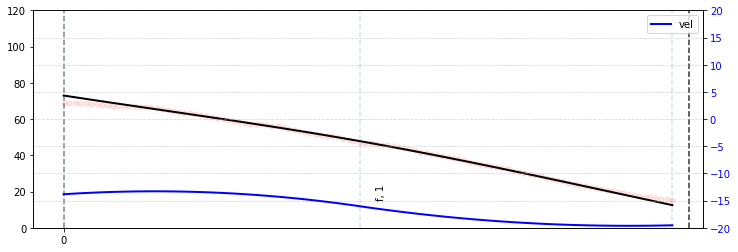

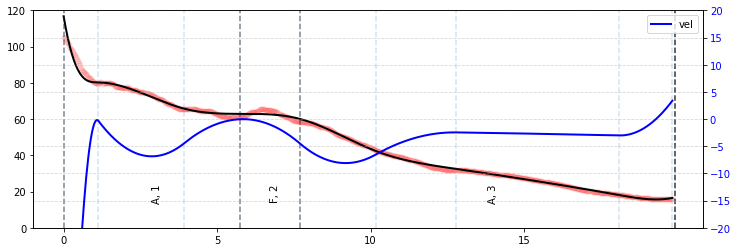

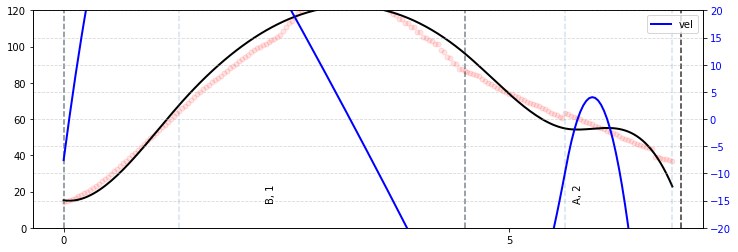

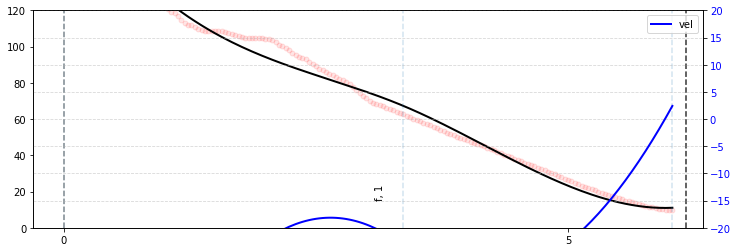

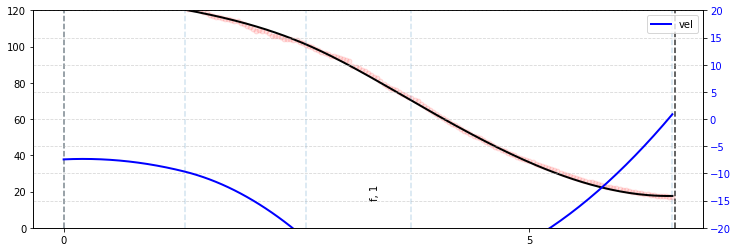

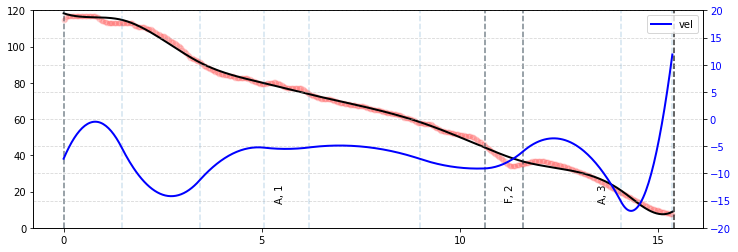

In [5]:
cnt = 0
dataset = pd.DataFrame()
not_processed = []
for j in annotations.filename:
    for i in name_of_csv_files_2018:
        if i == j:
            print("Processing file: ", j)
            try:
                file = [k for k in list_of_speed_files_2018 if k.split('/')[-1].split('.')[0][:-6] == j][0]
            except:
                print('Could not process ', j)
                print('Speed profile could not be found!')
                not_processed.append(j)
                break
            df_raw_speed = prepare_speed_profiles_for_model(file)
            file = [k for k in list_of_csv_files_2018 if k.split('/')[-1].split('.')[0] == j][0]
            df_detection = prepare_detections_for_model(file, df_raw_speed)
            df_detection_f = merge_speed_and_detection(df_detection, df_raw_speed, annotations, filename=i)
            phases, classes, segments = detect_phases(df_detection_f.dist, plot=True)
            df_detection_f['phases'] = phases
            dataset = pd.concat([dataset,df_detection_f])

            cnt += 1

    if cnt%10 == 0:
        print(len(list_of_speed_files_2018)-cnt, " files remained!")
        print(cnt, ' file processed!')
#         break

In [ ]:
#dataset.to_csv('../Data/dataset.csv')

In [ ]:
#dataframe= pd.DataFrame(not_processed)
#dataframe.to_csv('../Data/not_processed.csv')

In [115]:
dataset = pd.read_csv('../Data/dataset.csv')
not_processed = pd.read_csv('../Data/not_processed.csv')

In [116]:
dataset = dataset[['frame_num', 'dist', 'center', 'datetime_time',
       'Speed_MPH', 'filename', 'Type of vehicle', 'Type of road', 'phases']]

In [117]:
# dataset = dataset[dataset.dist < 30]
dataset['dist_standard'] = preprocessing.scale(dataset.dist)
# dataset = dataset[dataset.Speed_MPH < 30]
dataset['Speed_MPH_standard'] = preprocessing.scale(dataset.Speed_MPH)

In [118]:
dataset['hour'] = [datetime.datetime.strptime(str(i), '%H:%M:%S').hour for i in dataset.datetime_time]

In [119]:
# Monday is 0 and Sunday is 6
dataset['weekday'] = [datetime.datetime.strptime(i.split('_')[1], "%Y-%m-%d").weekday() for i in dataset.filename]

### Descriptive Analysis
#### (form here, all the analysis is conducted considering only _Following_ phase)

In [120]:
dataset = dataset[dataset.phases == "Following"]

In [91]:
dataset.head()

,frame_num,dist,center,datetime_time,Speed_MPH,filename,Type of vehicle,Type of road,phases,hour,weekday
243,672,75.358289,681.712916,20:40:16,17.168153,unit01_2018-09-26_20_38_20_1_2832,SUV,PAVED,Following,20,2
244,673,62.252500,680.667503,20:40:16,17.124349,unit01_2018-09-26_20_38_20_1_2832,SUV,PAVED,Following,20,2
245,674,62.252500,680.667503,20:40:16,17.080545,unit01_2018-09-26_20_38_20_1_2832,SUV,PAVED,Following,20,2
246,675,68.181310,682.044903,20:40:16,17.036741,unit01_2018-09-26_20_38_20_1_2832,SUV,PAVED,Following,20,2
247,676,68.181310,678.517686,20:40:16,16.992937,unit01_2018-09-26_20_38_20_1_2832,SUV,PAVED,Following,20,2


In [92]:
dataset.describe()

,frame_num,dist,center,Speed_MPH,hour,weekday
count,72569.000000,72569.000000,72569.000000,72569.000000,72569.000000,72569.000000
mean,3117.090590,33.497895,624.053300,19.249811,17.700437,3.444515
std,2939.746288,24.015318,56.721083,6.011292,3.155090,1.900103
min,0.000000,3.661912,288.794910,0.000000,0.000000,0.000000
25%,1331.000000,17.897594,596.181600,14.942878,15.000000,2.000000
50%,2257.000000,26.514954,627.174019,19.969765,18.000000,4.000000
75%,3819.000000,38.697500,650.877293,24.222149,20.000000,5.000000
max,19090.000000,204.543929,1058.362887,40.818167,23.000000,6.000000


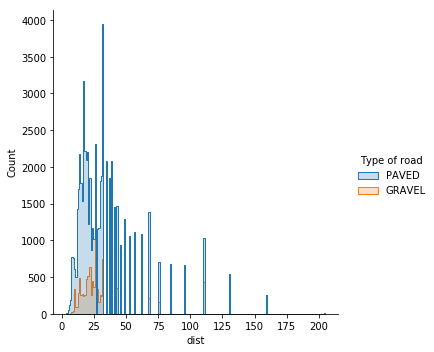

In [93]:
sns.displot(dataset, x="dist", hue="Type of road", element="step")

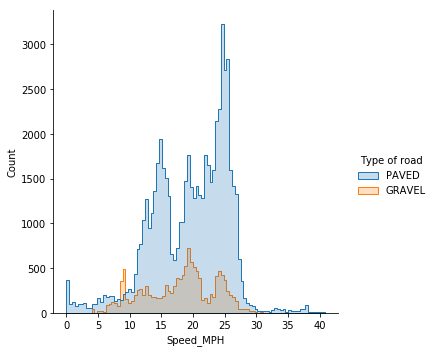

In [94]:
sns.displot(dataset, x="Speed_MPH", hue="Type of road", element="step")

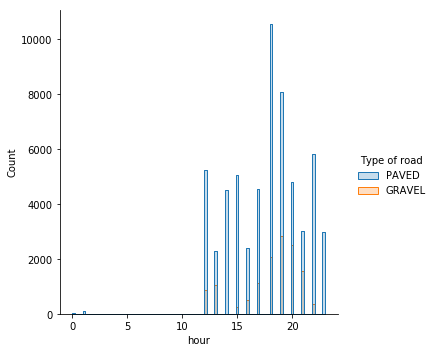

In [95]:
sns.displot(dataset, x="hour", hue="Type of road", element="step", )

Monday is 0 and Sunday is 6


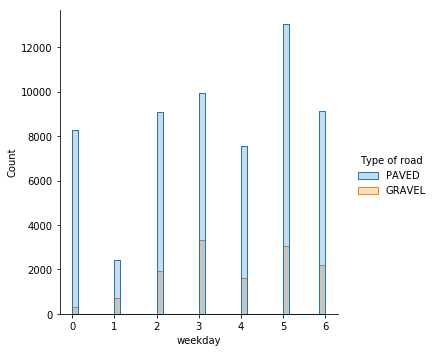

In [96]:
sns.displot(dataset, x="weekday", hue="Type of road", element="step")
print("Monday is 0 and Sunday is 6")

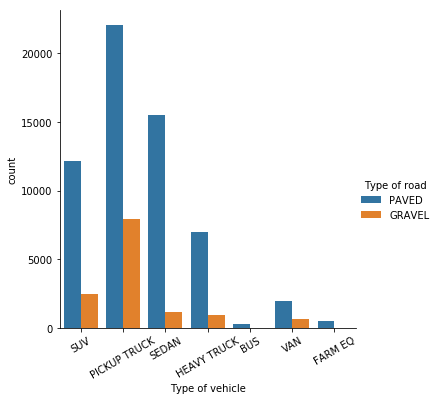

In [97]:
ax = sns.catplot(x="Type of vehicle", kind="count", hue="Type of road", data=dataset)
ax.set_xticklabels(rotation=30)

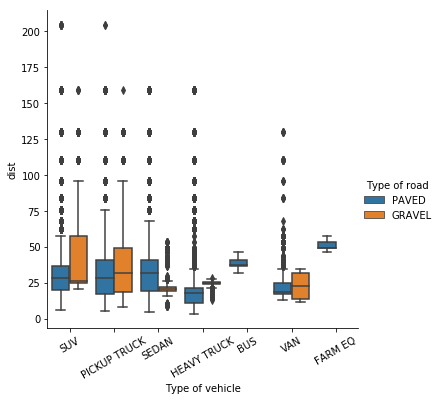

In [98]:
ax = sns.catplot(x="Type of vehicle", y="dist", hue="Type of road", kind="box", data=dataset)
ax.set_xticklabels(rotation=30)

### Removing the _HEAVY TRUCK, BUS, FARM EQ_ as we do not have relatively enough data point for them.

In [121]:
dataset = dataset[dataset['Type of vehicle'].isin(['SUV', 'VAN', 'PICKUP TRUCK', 'SEDAN'])]

In [122]:
dataset['Type of vehicle'] = dataset['Type of vehicle'].map({'SUV': 'CAR', 'VAN': 'CAR' ,'PICKUP TRUCK': 'PICKUP TRUCK',
                         'SEDAN': 'CAR'})

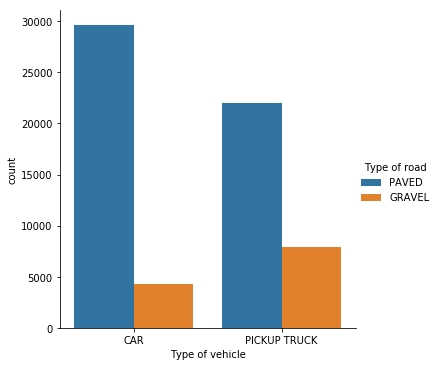

In [123]:
ax = sns.catplot(x="Type of vehicle", kind="count", hue="Type of road", data=dataset)

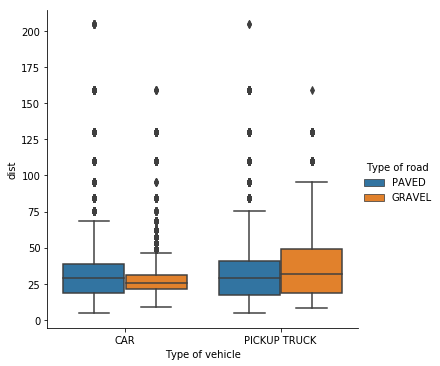

In [124]:
ax = sns.catplot(x="Type of vehicle", y="dist", hue="Type of road", kind="box", data=dataset)

In [125]:
dataset.weekday = [str(i) for i in dataset.weekday]

In [20]:
# dataset = dataset.groupby('filename').filter(lambda x : len(x)>10)

In [127]:
dataset.columns =['frame_num', 'dist', 'center', 'datetime_time', 'Speed_MPH', 'filename',
       'Type_of_vehicle', 'Type_of_road', 'phases', 'dist_standard',
       'Speed_MPH_standard', 'hour', 'weekday']

In [164]:
md = smf.mixedlm("dist_standard ~ Speed_MPH_standard + hour + C(weekday) + C(Type_of_vehicle) + C(Type_of_road)",
                 dataset, groups=dataset["filename"], re_formula="-1 + Speed_MPH")
mdf_rand_slop = md.fit()
print(mdf_rand_slop.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist_standard
No. Observations:        56477         Method:                   REML         
No. Groups:              181           Scale:                    0.0160       
Min. group size:         5             Log-Likelihood:           35901.7905   
Max. group size:         906           Converged:                Yes          
Mean group size:         312.0                                                
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          -0.014    0.055  -0.259 0.795 -0.122  0.093
C(weekday)[T.1]                    -0.208    0.022  -9.452 0.000 -0.251 -0.165
C(weekday)[T.2]                    -0.659    0.020 -32.746 0.000 -0.698 -

/Users/saeedarabi/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RMSE=  0.27120519086043227


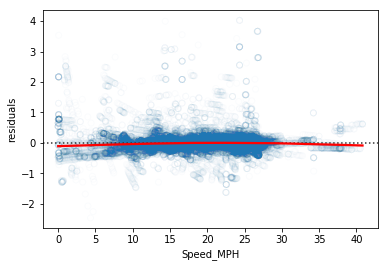

In [142]:
performance = pd.DataFrame()
performance["residuals"] = mdf_rand_slop.resid.values
performance["Speed_MPH"] = dataset.Speed_MPH.values
performance["predicted"] = mdf_rand_slop.fittedvalues.values
plt.figure()
ax = sns.residplot(x = "Speed_MPH", y = "residuals", data = performance, lowess=True, scatter_kws={'alpha':0.02, "facecolors":"None"}
                   , line_kws={'color': 'red'})
y_predict = mdf_rand_slop.fittedvalues.values
y = dataset.dist_standard.values
RMSE = math.sqrt(((y-y_predict)**2).mean())
print('RMSE= ', RMSE)

PAVED: red, GRAVEL: blue


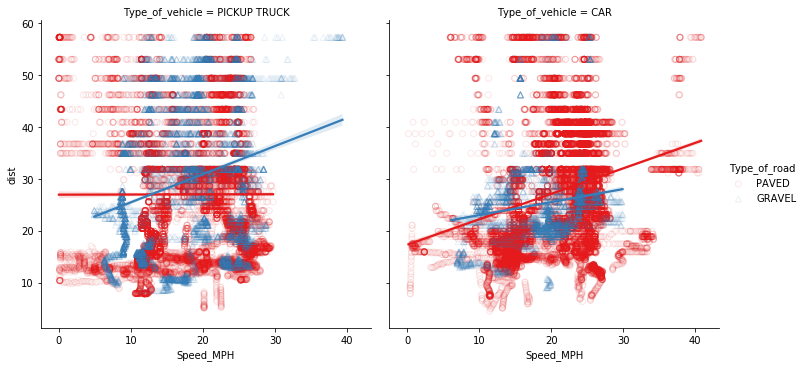

In [165]:
sns.lmplot(x = "Speed_MPH", y = "dist", data = dataset, scatter_kws={'alpha':0.1, 'facecolors':"None"},
           hue="Type_of_road", markers=["o", "^"], palette="Set1", col= "Type_of_vehicle")
print("PAVED: red, GRAVEL: blue")

CAR: red, HEAVY TRUCK: blue


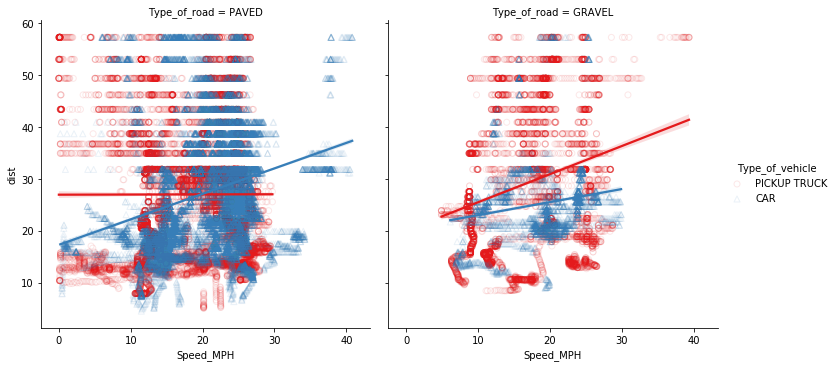

In [166]:
sns.lmplot(x = "Speed_MPH", y = "dist", data = dataset, scatter_kws={'alpha':0.1, 'facecolors':"None"},
           hue="Type_of_vehicle", markers=["o", "^"], palette="Set1", col= "Type_of_road")
print("CAR: red, HEAVY TRUCK: blue")

### We know that out distance estimation algorithm is not very reliable for distances further than 60(m). So, let's just keep the data that with distance less than 60(m) and redo the analysis.

In [146]:
dataset = dataset[dataset.dist < 60]

In [158]:
md = smf.mixedlm("dist_standard ~ 1 + Speed_MPH_standard + C(Type_of_vehicle) + C(Type_of_road)",
                 dataset, groups=dataset["filename"], re_formula="-1 + Speed_MPH")
mdf_rand_slop = md.fit()
print(mdf_rand_slop.summary())

                    Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       dist_standard
No. Observations:        56477         Method:                   REML         
No. Groups:              181           Scale:                    0.0165       
Min. group size:         5             Log-Likelihood:           35072.8032   
Max. group size:         906           Converged:                Yes          
Mean group size:         312.0                                                
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          -0.594    0.041 -14.430 0.000 -0.674 -0.513
C(Type_of_vehicle)[T.PICKUP TRUCK]  0.287    0.007  43.470 0.000  0.274  0.300
C(Type_of_road)[T.PAVED]            0.046    0.007   6.295 0.000  0.032  

/Users/saeedarabi/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2149: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


RMSE=  0.12811743942967582


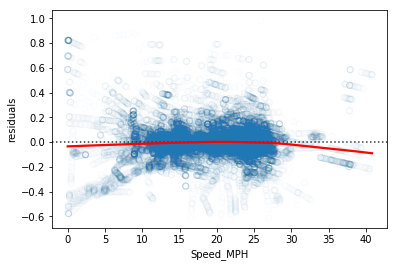

In [159]:
performance = pd.DataFrame()
performance["residuals"] = mdf_rand_slop.resid.values
performance["Speed_MPH"] = dataset.Speed_MPH.values
performance["predicted"] = mdf_rand_slop.fittedvalues.values
plt.figure()
ax = sns.residplot(x = "Speed_MPH", y = "residuals", data = performance, lowess=True, scatter_kws={'alpha':0.02, "facecolors":"None"}
                   , line_kws={'color': 'red'})
y_predict = mdf_rand_slop.fittedvalues.values
y = dataset.dist_standard.values
RMSE = math.sqrt(((y-y_predict)**2).mean())
print('RMSE= ', RMSE)

PAVED: red, GRAVEL: blue


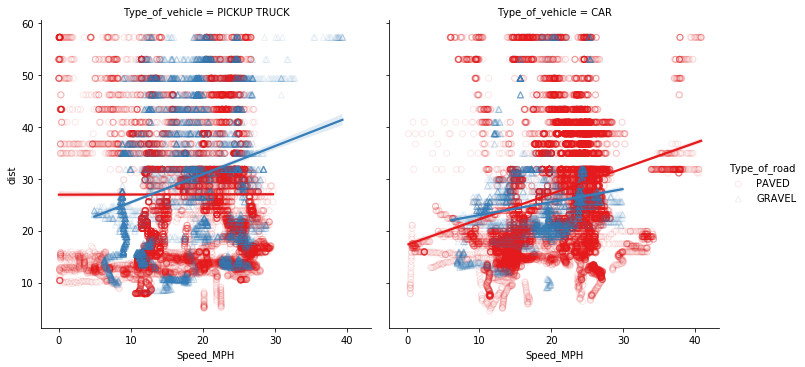

In [162]:
sns.lmplot(x = "Speed_MPH", y = "dist", data = dataset, scatter_kws={'alpha':0.1, 'facecolors':"None"},
           hue="Type_of_road", markers=["o", "^"], palette="Set1", col= "Type_of_vehicle")
print("PAVED: red, GRAVEL: blue")

CAR: red, HEAVY TRUCK: blue


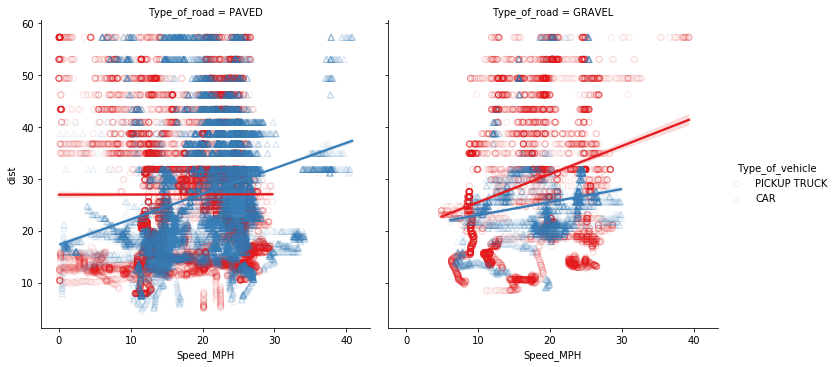

In [163]:
sns.lmplot(x = "Speed_MPH", y = "dist", data = dataset, scatter_kws={'alpha':0.1, 'facecolors':"None"},
           hue="Type_of_vehicle", markers=["o", "^"], palette="Set1", col= "Type_of_road")
print("CAR: red, HEAVY TRUCK: blue")